In [1]:
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ImageDir = 'predatasets/Dataset_1-20220314T131453Z-001/Dataset_1/'
files = []
for f in sorted(os.listdir(ImageDir), key=lambda x: int(os.path.splitext(x)[0])):
  files.append(ImageDir + "/" + f)
images = [cv2.imread(file) for file in files]

In [3]:
print("Number of Images : " , len(images))
print(f"Image dimensions : {images[0].shape}")

Number of Images :  33
Image dimensions : (720, 1280, 3)


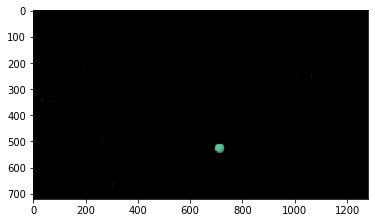

In [4]:
import numpy as np
import pandas as pd

# BGR 
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)

df = pd.DataFrame(columns = ['x', 'y'])

for i in images:
  img = i.copy()

  # converting color BGR 
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  
  # appyling mask to highligth green
  mask = cv2.inRange(hsv, greenLower, greenUpper)

  ## slice the green
  imask = mask>0
  green = np.zeros_like(img, np.uint8)
  green[imask] = img[imask]
    
  # showing the ball
  plt.imshow(green)

  # converting to gray image
  gray_image = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
    
  # removed blurred parts
  ret,thresh = cv2.threshold(gray_image,127,255,0)
  M = cv2.moments(thresh)

  # calculate centroid of visible patch
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])

  df.loc[len(df.index)] = [1280 - cX, 720 - cY]

  # drawing circle on the centroid
  cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
  cv2.putText(img, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)


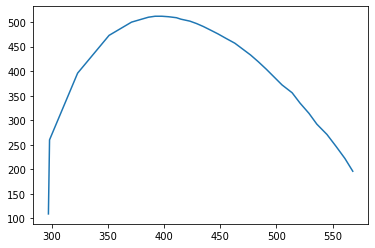

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)
df["x"] = df["x"].astype(int)
df["y"] = df["y"].astype(int)

plt.plot(df["x"], df["y"])

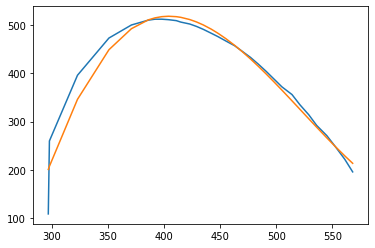

In [6]:
coefficients = np.polyfit(df["x"], df["y"], 3)
poly = np.poly1d(coefficients)

new_y = poly(df["x"])
df["predY"] = new_y
df["predY"] = df["predY"].astype(int)
plt.plot(df["x"], df["y"])
plt.plot(df["x"], new_y)

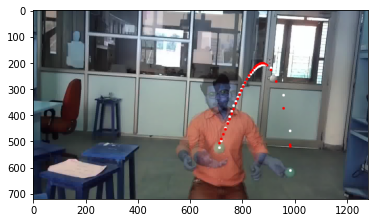

In [7]:
img1 = images[1].copy()
img2 = images[-1].copy()

img = cv2.addWeighted(img1, 0.5, img2, 0.5, 0.0)

cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)

for index, row in df.iterrows():
    cv2.circle(img, (1280 - row['x'], 720 - row['y']), 5, (255, 255, 255), -1)
    cv2.circle(img, (1280 - row['x'], 720 - row['predY']), 5, (255, 0, 0), -1)

plt.imshow(img)